In [170]:
import numpy as np
import time
import datetime
import json
import pandas as pd
import time

import mysql.connector
from mysql.connector import Error

from bokeh.plotting import *
from bokeh.layouts import gridplot
from bokeh.models import Span, ColumnDataSource, LogColorMapper, ColorMapper, LogTicker, ColorBar, BasicTicker, LinearColorMapper, PrintfTickFormatter, HoverTool, CategoricalColorMapper, Range1d, Title
from bokeh.models.widgets import Tabs, Panel
from bokeh.io import show, output_notebook
from bokeh.models.glyphs import Text
import bokeh.palettes as bp

# import hail as hl

import urllib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

from pathlib import Path
from joblib import Parallel, delayed

In [2]:
json_url = urllib.request.urlopen('https://api.helioviewer.org/?action=getDataSources')
hv_keys = json.loads(json_url.read())

In [3]:
hv_sid = pd.DataFrame(columns=['OBS','SOURCE_ID'])

# while sid=='sourceId':
#     key=hv_keys.keys()

for key1 in hv_keys.keys():
    for key2 in hv_keys[key1].keys():
        if 'sourceId' in hv_keys[key1][key2].keys(): 
            hv_sid.loc[len(hv_sid)] = " ".join([key1, key2]), hv_keys[key1][key2]['sourceId']
        else:
            for key3 in hv_keys[key1][key2].keys():
                if 'sourceId' in hv_keys[key1][key2][key3].keys(): 
                    hv_sid.loc[len(hv_sid)] = " ".join([key1, key2, key3]), hv_keys[key1][key2][key3]['sourceId']
                else:
                    for key4 in hv_keys[key1][key2][key3].keys():
                        if 'sourceId' in hv_keys[key1][key2][key3][key4].keys(): 
                            hv_sid.loc[len(hv_sid)] = " ".join([key1, key2, key3, key4]), hv_keys[key1][key2][key3][key4]['sourceId']
                        else:
                            for key5 in hv_keys[key1][key2][key3][key4].keys():
                                if 'sourceId' in hv_keys[key1][key2][key3][key4][key5].keys(): 
                                    hv_sid.loc[len(hv_sid)] = " ".join([key1, key2, key3, key4, key5]), hv_keys[key1][key2][key3][key4][key5]['sourceId']
                                else:
                                    for key6 in hv_keys[key1][key2][key3][key4][key5].keys():
                                        if 'sourceId' in hv_keys[key1][key2][key3][key4][key5][key6].keys(): 
                                            hv_sid.loc[len(hv_sid)] = " ".join([key1, key2, key3, key4, key5,key6]), hv_keys[key1][key2][key3][key4][key5][key6]['sourceId']    

In [4]:
hv_sid = hv_sid.sort_values(['SOURCE_ID']).reset_index(drop=True)
hv_sid

,OBS,SOURCE_ID
0,SOHO EIT 171,0
1,SOHO EIT 195,1
2,SOHO EIT 284,2
3,SOHO EIT 304,3
4,SOHO LASCO C2 white-light,4
...,...,...
72,Hinode XRT Al_poly Any,10009
73,Hinode XRT Be_med Any,10010
74,Hinode XRT Be_thin Any,10011
75,Hinode XRT C_poly Any,10012


In [5]:
def hv_prepare(cursor, sourceId, obs=None):
    hv = pd.DataFrame(cursor.fetchall(), columns=cursor.column_names)
    if(hv.empty):
        hv['SOURCE_ID']=[]
        return hv
    hv = hv.sort_values('date').reset_index(drop=True)
    hv['date'] = pd.to_datetime(hv['date'])
    hv = hv.set_index('date')
    hv = hv.reindex(pd.date_range(hv.index.min(), hv.index.max(), freq='D').to_period('D').to_timestamp(), 
                fill_value=0)
    hv = hv.reindex(pd.date_range(hv.index.min().replace(day=1), (hv.index.max() + pd.tseries.offsets.MonthEnd(1)), freq='D').to_period('D').to_timestamp(), 
                fill_value=-1)
    hv['date'] = hv.index
    hv = hv.reset_index(drop=True)
    hv.loc[hv['count']<0, 'count'] = np.nan
    hv['Year'] = hv['date'].dt.year.astype(str) + ' ' + hv['date'].dt.month_name()
    hv['Day'] = hv['date'].dt.day.astype(str)
    hv['SOURCE_ID'] = sourceId
    hv['OBS'] = obs
    return hv

In [6]:
def sql_query(sourceId, obs=None):
    try:
        connection = mysql.connector.connect(host='localhost',
                                             database='hv',
                                             user='hv_varun',
                                             password='Helioviewer@2020')

#         sql_select_Query = "SELECT filepath, date, sourceid FROM data WHERE sourceId=%d LIMIT 20;" %sourceId
    #     sql_select_Query = "SELECT sourceId, date_format(date, '%Y-%m-%d 00:00:00') as date, count(*) as count FROM data FORCE INDEX (date_index) WHERE sourceId=8 GROUP BY date_format(date, '%Y-%m-%d 00:00:00'), sourceId;"
        sql_select_Query = "SELECT date_format(date, '%Y-%m-%d 00:00:00') as date, count(*) as count FROM data FORCE INDEX (date_index) WHERE sourceId={} GROUP BY date_format(date, '%Y-%m-%d 00:00:00');".format(sourceId)
    #     sql_select_Query = "SELECT date_format(date, '%Y-%m-%d 00:00:00') as date, count(*) as count FROM data FORCE INDEX (date_index) GROUP BY date_format(date, '%Y-%m-%d 00:00:00');"
    #     sql_select_Query = "SELECT count(*) FROM data WHERE filepath LIKE '/AIA/1600/%';"
    #    sql_select_Query = "SELECT * FROM data LIMIT 20;"
        cursor = connection.cursor()
        cursor.execute(sql_select_Query)
        return hv_prepare(cursor, sourceId, obs)
#         records = cursor.fetchall()
    except Error as e:
        return 'ERROR at SOURCE ID %s: %s'%(sourceId, e)
        print("Error reading data from MySQL table", e)
    finally:
        print('asdf')
        if (connection.is_connected()):
            connection.close()
            cursor.close()

In [17]:
par = Parallel(n_jobs=20)
start_time=time.time()
results = par(delayed(sql_query)(df['SOURCE_ID'], df['OBS']) for ind, df in hv_sid.iterrows())
print(time.time()-start_time)

56.30772304534912


In [19]:
hv_obs = {}
for i in range(len(hv_sid)):
    if results[i].empty: 
        hv_sid = hv_sid.drop(index = hv_sid.index[hv_sid.index == i])
        continue
    hv_obs[hv_sid.iloc[i]['SOURCE_ID']] = results[i]
hv_obs

{0:       count       date          Year Day  SOURCE_ID           OBS
 0       NaN 1996-01-01  1996 January   1          0  SOHO EIT 171
 1       NaN 1996-01-02  1996 January   2          0  SOHO EIT 171
 2       NaN 1996-01-03  1996 January   3          0  SOHO EIT 171
 3       NaN 1996-01-04  1996 January   4          0  SOHO EIT 171
 4       NaN 1996-01-05  1996 January   5          0  SOHO EIT 171
 ...     ...        ...           ...  ..        ...           ...
 6448    NaN 2013-08-27   2013 August  27          0  SOHO EIT 171
 6449    NaN 2013-08-28   2013 August  28          0  SOHO EIT 171
 6450    NaN 2013-08-29   2013 August  29          0  SOHO EIT 171
 6451    NaN 2013-08-30   2013 August  30          0  SOHO EIT 171
 6452    NaN 2013-08-31   2013 August  31          0  SOHO EIT 171
 
 [6453 rows x 6 columns],
 1:       count       date          Year Day  SOURCE_ID           OBS
 0       NaN 1996-01-01  1996 January   1          1  SOHO EIT 195
 1       NaN 1996-01-02  199

In [18]:
# for ind, df in hv_sid[16:17].iterrows():
#     start_time=time.time()
#     print('INFO:', ind, df['SOURCE_ID'])
#     results = [sql_query(df['SOURCE_ID'])]
#     print(time.time()-start_time)

# Coverage

In [407]:
for sid in hv_obs.keys():# pd.DataFrame(hv_cov.stack(dropna=True), columns=['count']).reset_index()

    df = hv_obs[sid]

    name = df['OBS'].unique()[0]
    name_ = name.replace(" ", "_")

    years = np.array(df['Year'].unique()).astype(str)# hv_cov.index.values#.astype(str)
    days = df['Day'].unique().astype(str) # np.arange(1,32).astype(str)

    colors = bp.Viridis[256]# ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]

    TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

    # output_file('AIA1600_coverage.html')
    panels = []
    for mapper_type, mapper, ticker in zip(["log", "linear"],
                                           [LogColorMapper, LinearColorMapper],
                                           [LogTicker, BasicTicker]):
        p = figure(title="%s Coverage (%s - %s)"%(name, years[0], years[-1]),
        #            x_axis_type='datetime',
                   x_range=years, y_range=list(reversed(days)),
                   x_axis_location="above", plot_width=1500, plot_height=800,
                   x_axis_label="Year Month", y_axis_label="Date",
                   tooltips=[('Date', '@Year @Day'), ('#Data Files', '@count')],
                   tools=TOOLS, toolbar_location='below')

        total_days = (hv_obs[sid]['count']>=0).sum()
        total_files = (hv_obs[sid]['count']).sum()
        p.add_layout(Title(text="Total Files: %d"%total_files, text_font_style="italic"), 'above')
        p.add_layout(Title(text="Total Days: %d"%total_days, text_font_style="italic"), 'above')
        p.add_layout(Title(text="Source ID: %d"%df['SOURCE_ID'].unique()[0], text_font_style="italic"), 'above')

        # p.grid.grid_line_color = None
        p.axis.axis_line_color = None
        p.axis.major_tick_line_color = None
        p.axis.major_label_text_font_size = "7px"
        p.axis.major_label_standoff = 0
        p.xaxis.major_label_orientation = np.pi / 3
        p.xaxis.axis_label_text_font_size = "12pt"
        p.yaxis.axis_label_text_font_size = "12pt"
        p.xaxis.visible = True
        p.xgrid.visible = True

        p.xaxis.major_label_text_font_size = "7pt"
        p.yaxis.major_label_text_font_size = "8pt"


        p.rect(x="Year", y="Day", width=1, height=1,
               source=df,
               fill_color={'field': 'count', 'transform': mapper(palette=colors, low=1, high=np.nanmax(df['count']))},
               line_color=None)

        color_bar = ColorBar(color_mapper = mapper(palette=colors, low=1, high=np.nanmax(df['count'])), 
                             major_label_text_font_size="10px",
                             ticker=ticker(desired_num_ticks=10),
                             formatter=PrintfTickFormatter(format="%d"),
                             label_standoff=6, border_line_color=None, location=(0, 0))
        p.add_layout(color_bar, 'right')
        panel = Panel(child=p, title=mapper_type)
        panels.append(panel)
    output_file('%s_coverage.html'%name_)
    tabs = Tabs(tabs=panels)
#     show(tabs)
    save(tabs)

# Histogram

In [399]:
def interactive_histogram(df, sid, title, bin_size=None, log=None):
    
    arr_hist, edges, patches = plt.hist(df, bins=bin_size)
    cum_hist, cum_edges, patches = plt.hist(df, bins=bin_size, cumulative=True)
    plt.close()
    
    # Column data source
    df_hist = pd.DataFrame({'count': arr_hist, 'left': edges[:-1], 'right': edges[1:]})
    total = df_hist['count'].sum()
    df_hist['f_count'] = ['%d' % count for count in df_hist['count']]
    df_hist['f_percent'] = ['%.2f%%' %(count/total*100) for count in df_hist['count']]
    df_hist['f_interval'] = ['%d to %d ' % (left, right) for left, right in zip(df_hist['left'], df_hist['right'])]
    # column data source
    hist_src = ColumnDataSource(df_hist)
    
    #cumulative data
    cumulative_data = cum_hist#np.cumsum(arr_hist)
    x_bins = cum_edges[1:]#edges[1:]# np.arange(0, df.max(), bin_size)[1:]
    df_cum = pd.DataFrame({'count_cum': cumulative_data, 'x': x_bins})
    cum_src = ColumnDataSource(df_cum)
#     df_hist['f_count'] = np.log10(df_hist['f_count']+1)
    # Set up the figure same as before
    panels = []
    for axis_type in ["log","linear"]:
        p = figure(y_axis_type = axis_type,
                   title = "Histogram for %s"%title,
                   x_axis_label = 'No. of Data files', 
                   y_axis_label = 'Day count',
                   background_fill_color="#fafafa",
                   y_range = (0.9, df_hist['count'].max() + 100))
        # Add a quad glyph with source this time
        p.quad(bottom=0.9,
               top='count', 
               left='left', 
               right='right', 
               source=hist_src,
               fill_color='navy',
               alpha=0.5,
#                hover_fill_color='navy',
               hover_fill_alpha=0.2,
               line_color='white',
               legend='Histogram')
#         p.y_range(Range1d(0.8,df_hist['count'].max()))
        # Add style to the plot
        p.title.align = 'center'
        p.title.text_font_size = '18pt'
        p.xaxis.axis_label_text_font_size = '12pt'
        p.xaxis.major_label_text_font_size = '12pt'
        p.yaxis.axis_label_text_font_size = '12pt'
        p.yaxis.major_label_text_font_size = '12pt'
#         p.add_layout(Span(location=1800, dimension='height'))#, legend='Expected date file count'))
        
        total_days = (df>=0).sum()
        total_files = df.sum()
        
        p.add_layout(Title(text="Total Files: %d"%total_files, text_font_style="italic"), 'above')
        p.add_layout(Title(text="Total Days: %d"%total_days, text_font_style="italic"), 'above')
        p.add_layout(Title(text="Source ID: %d"%sid, text_font_style="italic"), 'above')
        
        p.legend.location = "top_left"
#         p.grid.grid_line_color="white"
        
#         text_source = ColumnDataSource(dict(x=[x_bins.max()*3/4],y=[df_hist['count'].max()*3/4],text=['Total Day Count = \n %d'%total]))
#         glyph = Text(x="x", y="y", text="text", text_color="black")
#         p.add_glyph(text_source, glyph)

        # Add a hover tool referring to the formatted columns
        hover = HoverTool(tooltips = [('#Data files', '@f_interval'),
                                      ('Day count', '@f_count'),
                                      ('Day count percentage', '@f_percent')])

        # Add the hover tool to the graph
        p.add_tools(hover)
        
        
        p2 = figure(y_axis_type=axis_type,
                   title = "Cumulative distribution for %s"%title,
                   x_axis_label = 'No. of Data files', 
                   y_axis_label = 'Day count',
                   background_fill_color="#fafafa")
        
        p2.line(x='x', y='count_cum', line_color='#036564', line_width=3, source=cum_src, hover_line_alpha=0.5, legend="Cumulative distribution")
        p2.circle(x='x', y='count_cum', line_color='#036564', line_width=5, source=cum_src, legend="Cumulative distribution" )
        hover = HoverTool(line_policy='nearest', tooltips = [('#Data files', '@x'), ('Cumulative Day count', '@count_cum')])
        
        p2.add_layout(Span(location=1800, dimension='height'))#, legend='Expected date file count'))
        # Add the hover tool to the graph
        p2.add_tools(hover)
        p2.title.align = 'center'
        p2.title.text_font_size = '18pt'
        p2.xaxis.axis_label_text_font_size = '12pt'
        p2.xaxis.major_label_text_font_size = '12pt'
        p2.yaxis.axis_label_text_font_size = '12pt'
        p2.yaxis.major_label_text_font_size = '12pt'
        p2.legend.location = "top_left"
        
        
        grid = gridplot([[p, p2]])#, plot_width=250, plot_height=250)
        panel = Panel(child=grid, title=axis_type)
        panels.append(panel)
    tabs = Tabs(tabs=panels)

    return tabs

In [446]:
for sid in hv_obs.keys():# pd.DataFrame(hv_cov.stack(dropna=True), columns=['count']).reset_index()

    df = hv_obs[sid].copy()
    name = df['OBS'].unique()[0]
    name_ = name.replace(" ", "_")
    
    df = df.dropna().reset_index(drop=True)
    f = open("./csv_files/%d_%s.csv"%(sid, name_), mode='w')
    f.write("# %s\n"%name)
    f.write("# %d\n"%sid)
    df.to_csv(f, columns=["date", "count", "SOURCE_ID", "OBS"], index=False)
    f.close()    
#     if len(df)<=10: 
#         print(len(df), sid)
# #         continue
    
    count = df['count']
    bin_size = 30#.astype(int)#100
    
#     btabs = interactive_histogram(count, sid, name, bin_size, log='log')
#     output_file('%s_histogram.html'%name_)
#     save(btabs)

In [278]:
arr_hist, edges = np.histogram(count)

In [266]:
arr_hist, edges

(array([  86,   18,   26,   35,  773, 1965,  644,  134,   19,   16]),
 array([   0. ,  359.5,  719. , 1078.5, 1438. , 1797.5, 2157. , 2516.5,
        2876. , 3235.5, 3595. ]))

In [276]:
arr_hist, edges, patches = plt.hist(count)
plt.close()#, cumulative=True)

In [275]:
arr_hist

array([  86.,   18.,   26.,   35.,  773., 1965.,  644.,  134.,   19.,
         16.])

In [59]:
hv_obs[62].dropna()

,count,date,Year,Day,SOURCE_ID,OBS
22,2.0,2007-03-23,2007 March,23,62,Hinode XRT C_poly Al_mesh
23,2.0,2007-03-24,2007 March,24,62,Hinode XRT C_poly Al_mesh


In [212]:
hv_obs[40].dropna()

,count,date,Year,Day,SOURCE_ID,OBS
12,1.0,2009-11-13,2009 November,13,40,Hinode XRT Al_med Be_thick


In [219]:
hv_obs[43].dropna()

,count,date,Year,Day,SOURCE_ID,OBS
24,5.0,2010-09-25,2010 September,25,43,Hinode XRT Al_med Ti_poly
25,0.0,2010-09-26,2010 September,26,43,Hinode XRT Al_med Ti_poly
26,0.0,2010-09-27,2010 September,27,43,Hinode XRT Al_med Ti_poly
27,0.0,2010-09-28,2010 September,28,43,Hinode XRT Al_med Ti_poly
28,0.0,2010-09-29,2010 September,29,43,Hinode XRT Al_med Ti_poly
29,0.0,2010-09-30,2010 September,30,43,Hinode XRT Al_med Ti_poly
30,0.0,2010-10-01,2010 October,1,43,Hinode XRT Al_med Ti_poly
31,0.0,2010-10-02,2010 October,2,43,Hinode XRT Al_med Ti_poly
32,0.0,2010-10-03,2010 October,3,43,Hinode XRT Al_med Ti_poly
33,0.0,2010-10-04,2010 October,4,43,Hinode XRT Al_med Ti_poly


40
43
62


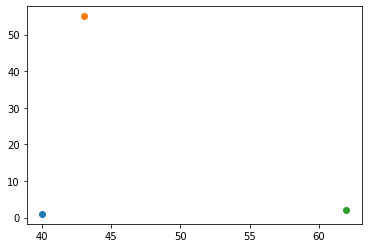

In [205]:
for key in hv_obs.keys():
    if len(hv_obs[key]) < 100: 
        plt.scatter(key, len(hv_obs[key].dropna().reset_index(drop=True)))
        print(key)